## Explore SYNTHEA data in the OMOP schema 

## Develop our cohort

In [78]:
#import all the packages
import psycopg2
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## import all the packages you need 
import psycopg2
#from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay
import matplotlib as mpl
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno

In [2]:
hostname = "spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com"
username = "introml568"
password = "m7bxMRtyMqPbcxyRRGML8"
database_name = "mimic"

In [3]:
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [4]:
omop_person = pd.read_sql("select * from omop.person", db_connection);
omop_visit = pd.read_sql("select * from omop.visit_occurrence", db_connection);

In [5]:
omop_visit.head()

,visit_occurrence_id,person_id,visit_concept_id,visit_start_date,visit_start_datetime,visit_end_date,visit_end_datetime,visit_type_concept_id,provider_id,care_site_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id,admitting_concept_id,discharge_to_source_concept_id
0,213,392776072,9201,2138-07-17,2138-07-17 19:04:00,2138-07-21,2138-07-21 15:48:00,44818518,None,397812313,NEWBORN,2001047001,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME,NaN,8940,2001051946
1,214,392776073,262,2101-10-20,2101-10-20 17:09:00,2101-10-31,2101-10-31 13:58:00,44818518,None,397812313,EMERGENCY,2001047000,2001046993,EMERGENCY ROOM ADMIT,8863,SNF,NaN,8870,2001051954
2,215,392776074,262,2191-03-15,2191-03-15 13:10:00,2191-03-23,2191-03-23 18:41:00,44818518,None,397812313,EMERGENCY,2001047000,2001046993,EMERGENCY ROOM ADMIT,8536,HOME WITH HOME IV PROVIDR,NaN,8870,2001051948
3,216,392776075,9201,2103-02-02,2103-02-02 04:31:00,2103-02-04,2103-02-04 12:15:00,44818518,None,397812313,NEWBORN,2001047001,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME,NaN,8940,2001051946
4,217,392776076,9201,2175-05-30,2175-05-30 07:15:00,2175-06-15,2175-06-15 16:00:00,44818518,None,397812313,ELECTIVE,2001046999,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME HEALTH CARE,NaN,8940,2001051947


## Start to derive required columns

In [5]:
#def person_age(birthdate):
#    """
#    defines age based on current date
#   """
#   difference_in_years = relativedelta(datetime.now(), birthdate).years
#   return difference_in_years

#omop_person['current_age'] = omop_person.birth_datetime.apply(person_age)

In [10]:
#inner join two tables
df = pd.merge(omop_person, omop_visit, on='person_id', how="inner")
col_keep = ['person_id', 'visit_occurrence_id', 'visit_start_date', 'visit_end_date', 'visit_start_datetime','visit_end_datetime', 'birth_datetime', 
            'gender_source_value', 'race_source_value', 'ethnicity_source_value']
df = df[col_keep]

In [11]:
df['age_at_visit'] = df.apply(lambda x: relativedelta(x['visit_start_datetime'], x['birth_datetime']).years, axis=1)
df['visit_length'] = df.apply(lambda x: relativedelta(x['visit_end_datetime'], x['visit_start_datetime']).hours, axis=1)
df.rename(columns={'gender_source_value': 'gender_concept_ID', 'race_source_value': 'race', 'ethnicity_source_value': 'ethnicity'}, inplace=True)
df.head(10)

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,gender_concept_ID,race,ethnicity,age_at_visit,visit_length
0,392820410,49790,2132-01-27,2132-02-02,2132-01-27 13:35:00,2132-02-02 11:40:00,2065-01-28,M,AMERICAN INDIAN/ALASKA NATIVE,None,66,22
1,392779593,3823,2150-01-08,2150-01-14,2150-01-08 10:15:00,2150-01-14 17:56:00,2117-09-03,F,AMERICAN INDIAN/ALASKA NATIVE,None,32,7
2,392800801,30456,2165-02-11,2165-02-13,2165-02-11 15:22:00,2165-02-13 19:08:00,2165-02-11,F,AMERICAN INDIAN/ALASKA NATIVE,None,0,3
3,392810738,47316,2111-04-01,2111-04-10,2111-04-01 17:55:00,2111-04-10 12:57:00,2070-08-26,M,AMERICAN INDIAN/ALASKA NATIVE,None,40,19
4,392779126,3077,2136-02-24,2136-03-25,2136-02-24 15:10:00,2136-03-25 14:10:00,2136-02-24,M,AMERICAN INDIAN/ALASKA NATIVE,None,0,23
5,392780371,5967,2153-06-06,2153-06-13,2153-06-06 21:31:00,2153-06-13 21:30:00,2153-06-06,M,AMERICAN INDIAN/ALASKA NATIVE,None,0,23
6,392780371,5968,2153-06-15,2153-06-19,2153-06-15 11:12:00,2153-06-19 14:00:00,2153-06-06,M,AMERICAN INDIAN/ALASKA NATIVE,None,0,2
7,392800654,29229,2146-01-28,2146-02-18,2146-01-28 15:13:00,2146-02-18 14:45:00,2146-01-28,M,AMERICAN INDIAN/ALASKA NATIVE,None,0,23
8,392794301,20659,2108-09-04,2108-09-10,2108-09-04 11:00:00,2108-09-10 13:30:00,2059-04-11,M,AMERICAN INDIAN/ALASKA NATIVE,None,49,2
9,392804824,32038,2156-06-01,2156-06-04,2156-06-01 10:00:00,2156-06-04 19:10:00,2093-05-29,M,AMERICAN INDIAN/ALASKA NATIVE,None,63,9


In [49]:
print(df)

       person_id  visit_occurrence_id visit_start_date visit_end_date  \
0      392820410                49790       2132-01-27     2132-02-02   
1      392779593                 3823       2150-01-08     2150-01-14   
2      392800801                30456       2165-02-11     2165-02-13   
3      392810738                47316       2111-04-01     2111-04-10   
4      392779126                 3077       2136-02-24     2136-03-25   
...          ...                  ...              ...            ...   
58971  392796781                39518       2173-12-08     2173-12-22   
58972  392800279                43831       2114-06-04     2114-06-15   
58973  392788217                14038       2161-02-19     2161-02-23   
58974  392802720                38477       2193-08-23     2193-08-27   
58975  392807535                47532       2146-10-31     2146-11-15   

      visit_start_datetime  visit_end_datetime birth_datetime  \
0      2132-01-27 13:35:00 2132-02-02 11:40:00     2065-01

## Inclusion Criteria

In [12]:
#people alive
# death = pd.read_sql("select * from omop.death", db_connection);
# df_alive = df[~df['person_id'].isin(death['person_id'])]

In [65]:
#filter age 50 - 75
df_age = df[(df['age_at_visit'] >= 50) & (df['age_at_visit'] <= 75)]

In [66]:
df_sorted = df_age.sort_values(by=['person_id', 'visit_start_date'])
df_limited_visits = df_sorted.groupby('person_id').head(20)

In [70]:
print(df_limited_visits)

       person_id  visit_occurrence_id visit_start_date visit_end_date  \
39586  392775850                  541       2149-12-17     2149-12-31   
39589  392775853                  546       2133-03-31     2133-04-23   
39590  392775853                  547       2133-08-15     2133-08-19   
17103  392775861                  559       2153-09-25     2153-09-28   
39600  392775862                  560       2160-01-09     2160-01-21   
...          ...                  ...              ...            ...   
27186  392822363                37287       2112-05-22     2112-05-25   
27187  392822363                37288       2112-05-28     2112-06-07   
10849  392822364                37289       2115-07-25     2115-07-30   
27191  392822368                37293       2129-01-03     2129-01-11   
27192  392822369                37294       2149-06-08     2149-06-23   

      visit_start_datetime  visit_end_datetime birth_datetime  \
39586  2149-12-17 11:10:00 2149-12-31 14:55:00     2075-03

## Combine Conditioning and Measurement with concept

In [15]:

omop_concept = pd.read_sql("select * from omop.concept", db_connection);
omop_condition = pd.read_sql("select * from omop.condition_occurrence", db_connection);

In [31]:
#condition - hypertension
df_condition = pd.merge(omop_condition, omop_concept[['concept_id', 'concept_name']], left_on='condition_concept_id', right_on='concept_id')

In [35]:
df_condition.head()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_date,condition_start_datetime,condition_end_date,condition_end_datetime,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,concept_id,concept_name
0,335970881,392783158,37116442,2170-01-30,2170-01-30 14:25:00,2170-02-13,2170-02-13 16:50:00,38000184,None,None,5509,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage
1,336090480,392793389,37116442,2178-03-14,2178-03-14 09:15:00,2178-03-18,2178-03-18 13:13:00,38000184,None,None,20988,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage
2,336350383,392800181,37116442,2195-01-21,2195-01-21 15:08:00,2195-01-26,2195-01-26 14:40:00,38000184,None,None,46752,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage
3,335996929,392787644,37116442,2152-02-28,2152-02-28 21:53:00,2152-03-05,2152-03-05 11:43:00,38000184,None,None,16341,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage
4,336349499,392807417,37116442,2182-08-17,2182-08-17 09:29:00,2182-08-22,2182-08-22 19:50:00,38000184,None,None,45566,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage


In [201]:
print(df_condition['condition_status_source_value'].unique())

[None]


In [200]:

# Step 1: Filter the conditions DataFrame to get rows that relate to Type 2 diabetes mellitus
type_2_diabetes_concepts = df_condition[df_condition['concept_name'].str.contains('Type 2 diabetes mellitus', case=False, na=False)]

# Step 2: Merge this with your main DataFrame on person_id
merged_df = pd.merge(df_limited_visits, type_2_diabetes_concepts[['person_id', 'concept_name']], on='person_id', how='left')

# Step 3: Add a column to `df_merge` that indicates the presence of 'Type 2 diabetes mellitus'
merged_df['condition - Type 2 diabetes'] = merged_df['concept_name'].apply(lambda x: 'Presence' if pd.notnull(x) and 'type 2 diabetes mellitus' in x.lower() else 'Absence')

# Now, merged_df has a new column 'condition - Type 2 diabetes' with the presence or absence of the condition
print(merged_df[['person_id', 'condition - Type 2 diabetes']].head())




   person_id condition - Type 2 diabetes
0  392775850                     Absence
1  392775853                     Absence
2  392775853                     Absence
3  392775861                     Absence
4  392775862                     Absence


In [120]:
merged_df.to_csv('C:/Users/12862/OneDrive/Desktop/Yale HW/output.csv', index=False)

In [69]:
print(merged_df['condition - Type 2 diabetes'].value_counts())

condition - Type 2 diabetes
Absence     24532
Presence     1276
Name: count, dtype: int64


In [7]:
csv_file_path = r'C:\Users\12862\OneDrive\Documents\GitHub\BIS568-final-project\BIS568-final-project\measurement\measurement.csv'

# Read the CSV file into a pandas DataFrame
df_measurement = pd.read_csv(csv_file_path)

# Show the first few rows of the DataFrame
print(df_measurement.head())

   measurement_concept_id  visit_occurrence_id          value_source_value
0                       0              31859.0           Adequate lighting
1                       0              31859.0           Adequate lighting
2                       0              31859.0         Bed alarm activated
3                       0              31859.0  Bed locked in low position
4                       0              31859.0           Family at bedside


In [8]:
#remove no matching data concept
df_measurement_filtered = df_measurement[df_measurement['measurement_concept_id'] != 0]

In [109]:
#including measure #1
df_meas = pd.merge(df_measurement_filtered, omop_concept[['concept_id', 'concept_name']], left_on='measurement_concept_id', right_on='concept_id')
meas_keep = ['visit_occurrence_id', 'concept_name', 'value_source_value']
df_meas = df_meas[meas_keep]

In [138]:
unique_concept_names = df_meas['concept_name'].unique()

# If you want to convert it to a list
unique_concept_names_list = list(unique_concept_names)

# Print the unique concept names
print(unique_concept_names_list)

['Left ventricular Cardiac index', 'Left ventricular Cardiac output', 'Left ventricular Stroke volume index', 'Stroke Volume Variation', 'Left ventricular Stroke volume', 'Systemic vascular Resistance index', 'Intracranial pressure (ICP)', 'Level of arousal', 'Oxygen saturation in Arterial blood', 'Systolic blood pressure', 'Oxygen gas flow Oxygen delivery system', 'Mean blood pressure', 'Bowel sounds', 'Cerebral perfusion pressure', 'Central venous pressure (CVP)', 'Resuscitation status', 'Dialysis', 'Glasgow coma score eye opening', 'Inhaled oxygen concentration', 'Glasgow coma scale', 'Heart rate', 'Heart rate rhythm', 'Respiratory rate', 'Line 1', 'Line 2', 'Line 3', 'Line 4', 'Line 5', 'Line 6', 'Line 7', 'Line 8', 'Mean pressure Respiratory system airway Calculated', 'Volume expired per minute Respiratory system', 'Glasgow coma score motor', 'Oxygen delivery', 'Pain severity - Reported', 'Pulmonary artery Mean blood pressure', 'PEEP Respiratory system', 'Pressure max Respiratory 

In [134]:
df_group = df_meas.groupby(['visit_occurrence_id','concept_name']).agg(group_value=('value_source_value',lambda x: list(x))).reset_index()

In [135]:
df_group.head()

,visit_occurrence_id,concept_name,group_value
0,1.0,Acetaminophen [Presence] in Serum or Plasma,[NEG]
1,1.0,Alanine aminotransferase [Enzymatic activity/v...,[19]
2,1.0,Alkaline phosphatase [Enzymatic activity/volum...,[75]
3,1.0,Amphetamines [Presence] in Urine,[NEG]
4,1.0,Amylase [Enzymatic activity/volume] in Serum o...,[37]


In [136]:
df_pivot = df_group.pivot(index='visit_occurrence_id',columns='concept_name',values='group_value').reset_index()

In [154]:
diabetes_features = [
    'Glucose [Mass/volume] in Blood',
    'Hemoglobin A1c/Hemoglobin.total in Blood',
    'Creatinine [Mass/volume] in Serum or Plasma',
    'Urea nitrogen [Mass/volume] in Serum or Plasma',
    'Sodium [Moles/volume] in Serum or Plasma',
    'Potassium [Moles/volume] in Serum or Plasma',
    'Chloride [Moles/volume] in Serum or Plasma',
    'Calcium [Moles/volume] in Serum or Plasma',
    'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
    'Bilirubin.total [Mass/volume] in Serum or Plasma',
    'Albumin [Mass/volume] in Serum or Plasma',
    'Protein [Mass/volume] in Serum or Plasma',
    'Hematocrit [Volume Fraction] of Blood by Automated count',
    'Hemoglobin [Mass/volume] in Blood',
    'Platelets [#/volume] in Blood by Automated count',
    'Lymphocytes [#/volume] in Blood',
    'Leukocytes [#/volume] in Blood',
    'C reactive protein [Mass/volume] in Serum or Plasma',
    'Body weight',
    'Body height',
    'Body temperature',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Mean blood pressure',
    'Heart rate',
    'Oxygen saturation in Arterial blood',
    'Cholesterol [Mass/volume] in Serum or Plasma',
    'Triglyceride [Mass/volume] in Serum or Plasma --12 hours fasting' ,
    'Cholesterol in HDL [Mass/volume] in Serum or Plasma',
    'Cholesterol in LDL [Mass/volume] in Serum or Plasma by Direct assay',
    'Natriuretic peptide.B prohormone N-Terminal [Mass/volume] in Serum or Plasma',
    'Erythrocyte distribution width [Ratio] by Automated count',
    'MCV [Entitic volume] by Automated count',
    'Protein/Creatinine [Mass Ratio] in Urine',
    'Urine output',
    'Urate [Mass/volume] in Serum or Plasma',
    'Urate [Mass/volume] in Urine',
    'pH of Urine by Test strip',
    'Protein [Mass/volume] in Urine by Test strip',
    'Nitrite [Presence] in Urine by Test strip',
    'Ketones [Mass/volume] in Urine by Test strip',
    'Bicarbonate [Moles/volume] in Serum or Plasma',
    'Carbon dioxide, total [Moles/volume] in Blood by calculation',
    'Oxygen/Inspired gas setting [Volume Fraction] Ventilator',
    'Respiratory rate',
    'Tidal volume Ventilator --on ventilator',
    'Fibrin+Fibrinogen fragments [Mass/volume] in Platelet poor plasma',
    'Glasgow coma score eye opening',
    'Glasgow coma score motor',
    'Glasgow coma score verbal',
    'Glasgow coma scale',
    'Pain severity - Reported',
    'Pain assessment',
    'Pain management',
    'Eosinophils [#/volume] in Blood',
    'Monocytes [#/volume] in Blood by Automated count',
    'Nucleated erythrocytes [#/volume] in Blood by Manual count',
    'Prothrombin time (PT)',
    'aPTT in Blood by Coagulation assay',
    'Lactate [Moles/volume] in Blood',
    'Lactate dehydrogenase [Enzymatic activity/volume] in Serum or Plasma',
    'Erythrocytes [#/volume] in Blood by Automated count',
    'Basophils [#/volume] in Blood by Automated count',
    'Band form neutrophils [#/volume] in Blood',
    'Thyrotropin [Units/volume] in Serum or Plasma',
    'Thyroxine (T4) [Mass/volume] in Serum or Plasma',
    'Thyroxine (T4) free [Mass/volume] in Serum or Plasma',
    'Cortisol [Mass/volume] in Serum or Plasma',
    'Calcidiol [Mass/volume] in Serum or Plasma',
    'Testosterone [Mass/volume] in Serum or Plasma',
    'Estradiol (E2) [Mass/volume] in Serum or Plasma',
    'Carcinoembryonic Ag [Mass/volume] in Serum or Plasma',
    'Cancer Ag 125 [Units/volume] in Serum or Plasma',
    'Prostate specific Ag [Mass/volume] in Serum or Plasma',
    'Iron [Mass/volume] in Serum or Plasma',
    'Ferritin [Mass/volume] in Serum or Plasma',
    'Folate [Mass/volume] in Serum or Plasma',
    'Magnesium [Moles/volume] in Serum or Plasma',
    'Phosphate [Mass/volume] in Serum or Plasma',
    'Calcium.ionized [Moles/volume] in Blood',
    'visit_occurrence_id'
]

# Now you can use this list to filter your DataFrame 'df_pivot' to contain only these features
df_pivot_filtered = df_pivot[diabetes_features]


In [155]:
df_selected = pd.merge(merged_df, df_pivot_filtered, on='visit_occurrence_id', how='left')

In [156]:
df_selected.head()

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,gender_concept_ID,race,ethnicity,...,Estradiol (E2) [Mass/volume] in Serum or Plasma,Carcinoembryonic Ag [Mass/volume] in Serum or Plasma,Cancer Ag 125 [Units/volume] in Serum or Plasma,Prostate specific Ag [Mass/volume] in Serum or Plasma,Iron [Mass/volume] in Serum or Plasma,Ferritin [Mass/volume] in Serum or Plasma,Folate [Mass/volume] in Serum or Plasma,Magnesium [Moles/volume] in Serum or Plasma,Phosphate [Mass/volume] in Serum or Plasma,Calcium.ionized [Moles/volume] in Blood
0,392775850,541,2149-12-17,2149-12-31,2149-12-17 11:10:00,2149-12-31 14:55:00,2075-03-13,F,WHITE,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.5, 1.5, 2.0, 2.9, 2.8, 2.2, 2.2, 1.9, 1.8, ...","[2.9, 2.7, 3.3, 3.4, 2.7, 6.8, 6.0, 4.7, 4.0]","[1.14, 1.20, 1.21, 1.14, 1.24]"
1,392775853,546,2133-03-31,2133-04-23,2133-03-31 03:58:00,2133-04-23 15:00:00,2078-03-06,M,WHITE,None,...,NaN,NaN,NaN,NaN,[84],[816],NaN,"[1.8, 1.9, 1.2, 1.8, 1.6, 1.7, 1.5, 2.0, 1.5, ...","[3.7, 2.4, 5.2, 3.1, 2.6, 3.3, 2.7, 3.2, 2.9, ...","[1.03, 1.02, 1.07, 1.15, 1.13, 1.15, 1.19]"
2,392775853,547,2133-08-15,2133-08-19,2133-08-15 01:42:00,2133-08-19 17:30:00,2078-03-06,M,WHITE,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.6, 1.7, 1.8, 1.6]","[3.7, 3.5, 3.5, 3.4]",NaN
3,392775861,559,2153-09-25,2153-09-28,2153-09-25 18:01:00,2153-09-28 18:48:00,2090-01-05,M,UNKNOWN/NOT SPECIFIED,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.9, 2.4, 1.9, 2.0]","[1.9, 2.3]",NaN
4,392775862,560,2160-01-09,2160-01-21,2160-01-09 11:42:00,2160-01-21 16:15:00,2104-06-18,M,WHITE,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.7, 1.9, 1.8, 1.6, 1.7, 1.7, 1.9, 1.8, 1.9, ...","[3.5, 3.6, 3.9, 2.9, 2.6, 3.1, 3.2, 3.3, 3.2, ...",NaN


In [159]:


def expand_lists_in_dataframe(df, list_columns):
    # List to hold the dictionaries
    rows_list = []
    
    # Iterate over each row in the original DataFrame
    for idx, row in df.iterrows():
        # Find the maximum length of lists in this row for the specified columns
        max_length = max(len(row[col]) if isinstance(row[col], list) else 0 for col in list_columns)
        
        # Create new rows based on the maximum length
        for i in range(max_length):
            # Create a dictionary for each new row
            new_row = {}
            for col in list_columns:
                # Try to get the value at the current index if it exists, otherwise fill with NaN
                new_row[col] = row[col][i] if isinstance(row[col], list) and i < len(row[col]) else np.nan
            # Add the 'visit_occurrence_id' to each new row
            new_row['visit_occurrence_id'] = row['visit_occurrence_id']
            # Append the new row dictionary to the rows list
            rows_list.append(new_row)
    
    # Convert the list of dictionaries to a DataFrame
    expanded_df = pd.DataFrame(rows_list)
    return expanded_df

# List of columns that contain lists to be expanded
list_columns = [
    'Glucose [Mass/volume] in Blood',
    'Hemoglobin A1c/Hemoglobin.total in Blood',
    'Creatinine [Mass/volume] in Serum or Plasma',
    'Urea nitrogen [Mass/volume] in Serum or Plasma',
    'Sodium [Moles/volume] in Serum or Plasma',
    'Potassium [Moles/volume] in Serum or Plasma',
    'Chloride [Moles/volume] in Serum or Plasma',
    'Calcium [Moles/volume] in Serum or Plasma',
    'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
    'Bilirubin.total [Mass/volume] in Serum or Plasma',
    'Albumin [Mass/volume] in Serum or Plasma',
    'Protein [Mass/volume] in Serum or Plasma',
    'Hematocrit [Volume Fraction] of Blood by Automated count',
    'Hemoglobin [Mass/volume] in Blood',
    'Platelets [#/volume] in Blood by Automated count',
    'Lymphocytes [#/volume] in Blood',
    'Leukocytes [#/volume] in Blood',
    'C reactive protein [Mass/volume] in Serum or Plasma',
    'Body weight',
    'Body height',
    'Body temperature',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Mean blood pressure',
    'Heart rate',
    'Oxygen saturation in Arterial blood',
    'Cholesterol [Mass/volume] in Serum or Plasma',
    'Triglyceride [Mass/volume] in Serum or Plasma --12 hours fasting' ,
    'Cholesterol in HDL [Mass/volume] in Serum or Plasma',
    'Cholesterol in LDL [Mass/volume] in Serum or Plasma by Direct assay',
    'Natriuretic peptide.B prohormone N-Terminal [Mass/volume] in Serum or Plasma',
    'Erythrocyte distribution width [Ratio] by Automated count',
    'MCV [Entitic volume] by Automated count',
    'Protein/Creatinine [Mass Ratio] in Urine',
    'Urine output',
    'Urate [Mass/volume] in Serum or Plasma',
    'Urate [Mass/volume] in Urine',
    'pH of Urine by Test strip',
    'Protein [Mass/volume] in Urine by Test strip',
    'Nitrite [Presence] in Urine by Test strip',
    'Ketones [Mass/volume] in Urine by Test strip',
    'Bicarbonate [Moles/volume] in Serum or Plasma',
    'Carbon dioxide, total [Moles/volume] in Blood by calculation',
    'Oxygen/Inspired gas setting [Volume Fraction] Ventilator',
    'Respiratory rate',
    'Tidal volume Ventilator --on ventilator',
    'Fibrin+Fibrinogen fragments [Mass/volume] in Platelet poor plasma',
    'Glasgow coma score eye opening',
    'Glasgow coma score motor',
    'Glasgow coma score verbal',
    'Glasgow coma scale',
    'Pain severity - Reported',
    'Pain assessment',
    'Pain management',
    'Eosinophils [#/volume] in Blood',
    'Monocytes [#/volume] in Blood by Automated count',
    'Nucleated erythrocytes [#/volume] in Blood by Manual count',
    'Prothrombin time (PT)',
    'aPTT in Blood by Coagulation assay',
    'Lactate [Moles/volume] in Blood',
    'Lactate dehydrogenase [Enzymatic activity/volume] in Serum or Plasma',
    'Erythrocytes [#/volume] in Blood by Automated count',
    'Basophils [#/volume] in Blood by Automated count',
    'Band form neutrophils [#/volume] in Blood',
    'Thyrotropin [Units/volume] in Serum or Plasma',
    'Thyroxine (T4) [Mass/volume] in Serum or Plasma',
    'Thyroxine (T4) free [Mass/volume] in Serum or Plasma',
    'Cortisol [Mass/volume] in Serum or Plasma',
    'Calcidiol [Mass/volume] in Serum or Plasma',
    'Testosterone [Mass/volume] in Serum or Plasma',
    'Estradiol (E2) [Mass/volume] in Serum or Plasma',
    'Carcinoembryonic Ag [Mass/volume] in Serum or Plasma',
    'Cancer Ag 125 [Units/volume] in Serum or Plasma',
    'Prostate specific Ag [Mass/volume] in Serum or Plasma',
    'Iron [Mass/volume] in Serum or Plasma',
    'Ferritin [Mass/volume] in Serum or Plasma',
    'Folate [Mass/volume] in Serum or Plasma',
    'Magnesium [Moles/volume] in Serum or Plasma',
    'Phosphate [Mass/volume] in Serum or Plasma',
    'Calcium.ionized [Moles/volume] in Blood',
]

expanded_df = expand_lists_in_dataframe(df_selected, list_columns)

# Now you have `expanded_df` where each list is expanded into separate rows.


In [160]:
print(expanded_df)

        Glucose [Mass/volume] in Blood  \
0                                  209   
1                                  209   
2                                  188   
3                                  198   
4                                  NaN   
...                                ...   
5081828                            NaN   
5081829                            NaN   
5081830                            NaN   
5081831                            NaN   
5081832                            NaN   

        Hemoglobin A1c/Hemoglobin.total in Blood  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
5081828                                      NaN   
5081829                                      NaN   
5081830                    

In [167]:
col_keep2 = ['person_id', 'visit_occurrence_id','birth_datetime','gender_concept_ID', 'race', 'ethnicity', 'age_at_visit', 'condition - Type 2 diabetes']
merged_df2 = merged_df[col_keep2]

In [168]:
df_trans = pd.merge(expanded_df, merged_df2, on='visit_occurrence_id', how='left')

In [182]:
df_trans.head()

,Glucose [Mass/volume] in Blood,Hemoglobin A1c/Hemoglobin.total in Blood,Creatinine [Mass/volume] in Serum or Plasma,Urea nitrogen [Mass/volume] in Serum or Plasma,Sodium [Moles/volume] in Serum or Plasma,Potassium [Moles/volume] in Serum or Plasma,Chloride [Moles/volume] in Serum or Plasma,Calcium [Moles/volume] in Serum or Plasma,Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma,...,Phosphate [Mass/volume] in Serum or Plasma,Calcium.ionized [Moles/volume] in Blood,visit_occurrence_id,person_id,birth_datetime,gender_concept_ID,race,ethnicity,age_at_visit,condition - Type 2 diabetes
0,209,NaN,1.3,41,138,4.2,101,8.8,118,79,...,2.9,1.14,541,392775850,2075-03-13,F,WHITE,None,74,Absence
1,209,NaN,1.2,31,138,4.1,102,9.0,123,79,...,2.7,1.20,541,392775850,2075-03-13,F,WHITE,None,74,Absence
2,188,NaN,1.2,27,137,3.8,102,8.3,118,71,...,3.3,1.21,541,392775850,2075-03-13,F,WHITE,None,74,Absence
3,198,NaN,1.2,51,143,4.0,106,8.9,NaN,NaN,...,3.4,1.14,541,392775850,2075-03-13,F,WHITE,None,74,Absence
4,NaN,NaN,1.2,53,148,4.3,110,9.0,NaN,NaN,...,2.7,1.24,541,392775850,2075-03-13,F,WHITE,None,74,Absence


In [170]:
df_trans.to_csv('C:/Users/12862/OneDrive/Desktop/Yale HW/dat.csv', index=False)

## Exclusion criteria

Exclude rows where all measurement columns are Na

In [171]:
# Identify measurement columns (all columns before 'visit_occurrence_id')
measurement_columns = df_trans.columns[:df_trans.columns.get_loc('visit_occurrence_id')]

# Exclude rows where all measurement columns are NaN
df_cleaned1 = df_trans.dropna(subset=measurement_columns, how='all')

Exclude people with renal impairment by using creatinine levels limit for Male and Female

In [177]:
df_cleaned1['Creatinine [Mass/volume] in Serum or Plasma'] = pd.to_numeric(df_cleaned1['Creatinine [Mass/volume] in Serum or Plasma'], errors='coerce')
# Renal impairment exclusion
# Assuming the upper limit for women is 1.4 and for men is 1.5 for creatinine levels
# Assuming gender is coded as 'M' for male and 'F' for female in 'gender_concept_ID' column
# We will use a simple condition assuming all 'M' are men and all 'F' are women
df_cleaned1 = df_cleaned1[((df_cleaned1['Creatinine [Mass/volume] in Serum or Plasma'] <= 1.4) & 
                           (df_cleaned1['gender_concept_ID'] == 'F')) | 
                          ((df_cleaned1['Creatinine [Mass/volume] in Serum or Plasma'] <= 1.5) & 
                           (df_cleaned1['gender_concept_ID'] == 'M')) | 
                          (df_cleaned1['Creatinine [Mass/volume] in Serum or Plasma'].isna())]

Exclude people with Type I diabetes

In [203]:
#build column to justify Type 1 diabetes
type_1_diabetes_concepts = df_condition[df_condition['concept_name'].str.contains('Type 1 diabetes mellitus', case=False, na=False)]
df_cleaned2 = pd.merge(df_cleaned1, type_1_diabetes_concepts[['person_id', 'concept_name']], on='person_id', how='left')
# Add a column to `df_cleaned2` that indicates the presence of 'Type 1 diabetes mellitus'
df_cleaned2['condition - Type 1 diabetes'] = merged_df['concept_name'].apply(lambda x: 'Presence' if pd.notnull(x) and 'type 1 diabetes mellitus' in x.lower() else 'Absence')

In [204]:
# Step 3: Add a column to `df_cleaned2` that indicates the presence of 'Type 1 diabetes mellitus'
df_cleaned2['condition - Type 1 diabetes'] = df_cleaned2['concept_name'].apply(lambda x: 'Presence' if pd.notnull(x) and 'type 1 diabetes mellitus' in x.lower() else 'Absence')

In [208]:
df_cleaned2 = df_cleaned2[df_cleaned2['condition - Type 1 diabetes'] != 'Presence']

In [209]:
print(df_cleaned2['condition - Type 1 diabetes'].value_counts())

condition - Type 1 diabetes
Absence    4157787
Name: count, dtype: int64


In [210]:
print(df_cleaned2['condition - Type 2 diabetes'].value_counts())

condition - Type 2 diabetes
Absence     3897032
Presence     260755
Name: count, dtype: int64


## EDA Process

Demographical features visualization

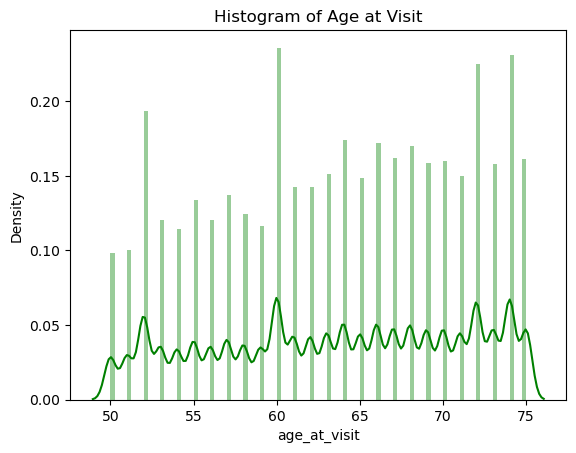

In [211]:
# create histogram for age_at_visit
sns.distplot(df_cleaned2['age_at_visit'], color='g', bins=100, hist_kws={'alpha': 0.4});
plt.title('Histogram of Age at Visit');
plt.show()

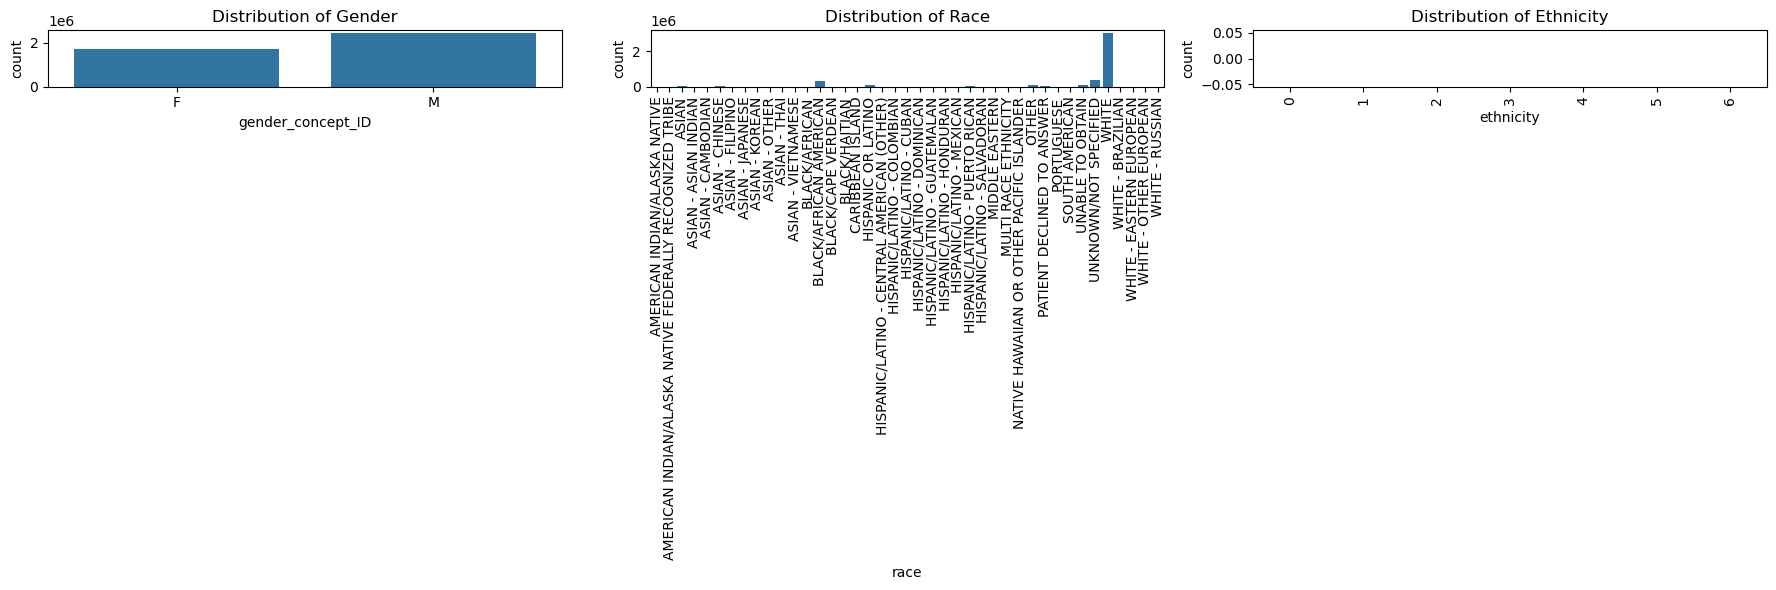

In [212]:
df_cleaned2['gender_concept_ID'] = df_cleaned2['gender_concept_ID'].astype('category')
df_cleaned2['race'] = df_cleaned2['race'].astype('category')
df_cleaned2['ethnicity'] = df_cleaned2['ethnicity'].astype('category')

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the figsize as needed

# Gender distribution
sns.countplot(x='gender_concept_ID', data=df_cleaned2, ax=axes[0])
axes[0].set_title('Distribution of Gender')

# Race distribution - if there are too many categories, we might only want to show the top N
top_races = df_cleaned2['race'].value_counts().index[:10]  # Adjust N as needed
sns.countplot(x='race', data=df_cleaned2[df_cleaned2['race'].isin(top_races)], ax=axes[1])
axes[1].set_title('Distribution of Race')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

# Ethnicity distribution
sns.countplot(x='ethnicity', data=df_cleaned2, ax=axes[2])
axes[2].set_title('Distribution of Ethnicity')
axes[2].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

plt.tight_layout()
plt.show()

In [223]:
#remove useless columns in prediction
df_cleaned3 = df_cleaned2.drop(columns=['condition - Type 1 diabetes', 'concept_name', 'birth_datetime'])

In [224]:
#Since there's no ethnicity data, we can just simply remove this column
df_cleaned3 = df_cleaned3.drop(columns=['ethnicity'])

In [225]:
df_cleaned3 = df_cleaned3.dropna(subset=measurement_columns, how='all')

In [221]:
df_subset = df_cleaned3.iloc[:100000]
df_subset.to_csv('C:/Users/12862/OneDrive/Desktop/Yale HW/dat.csv', index=False)

Go review all the features and start feature selection process

<Axes: >

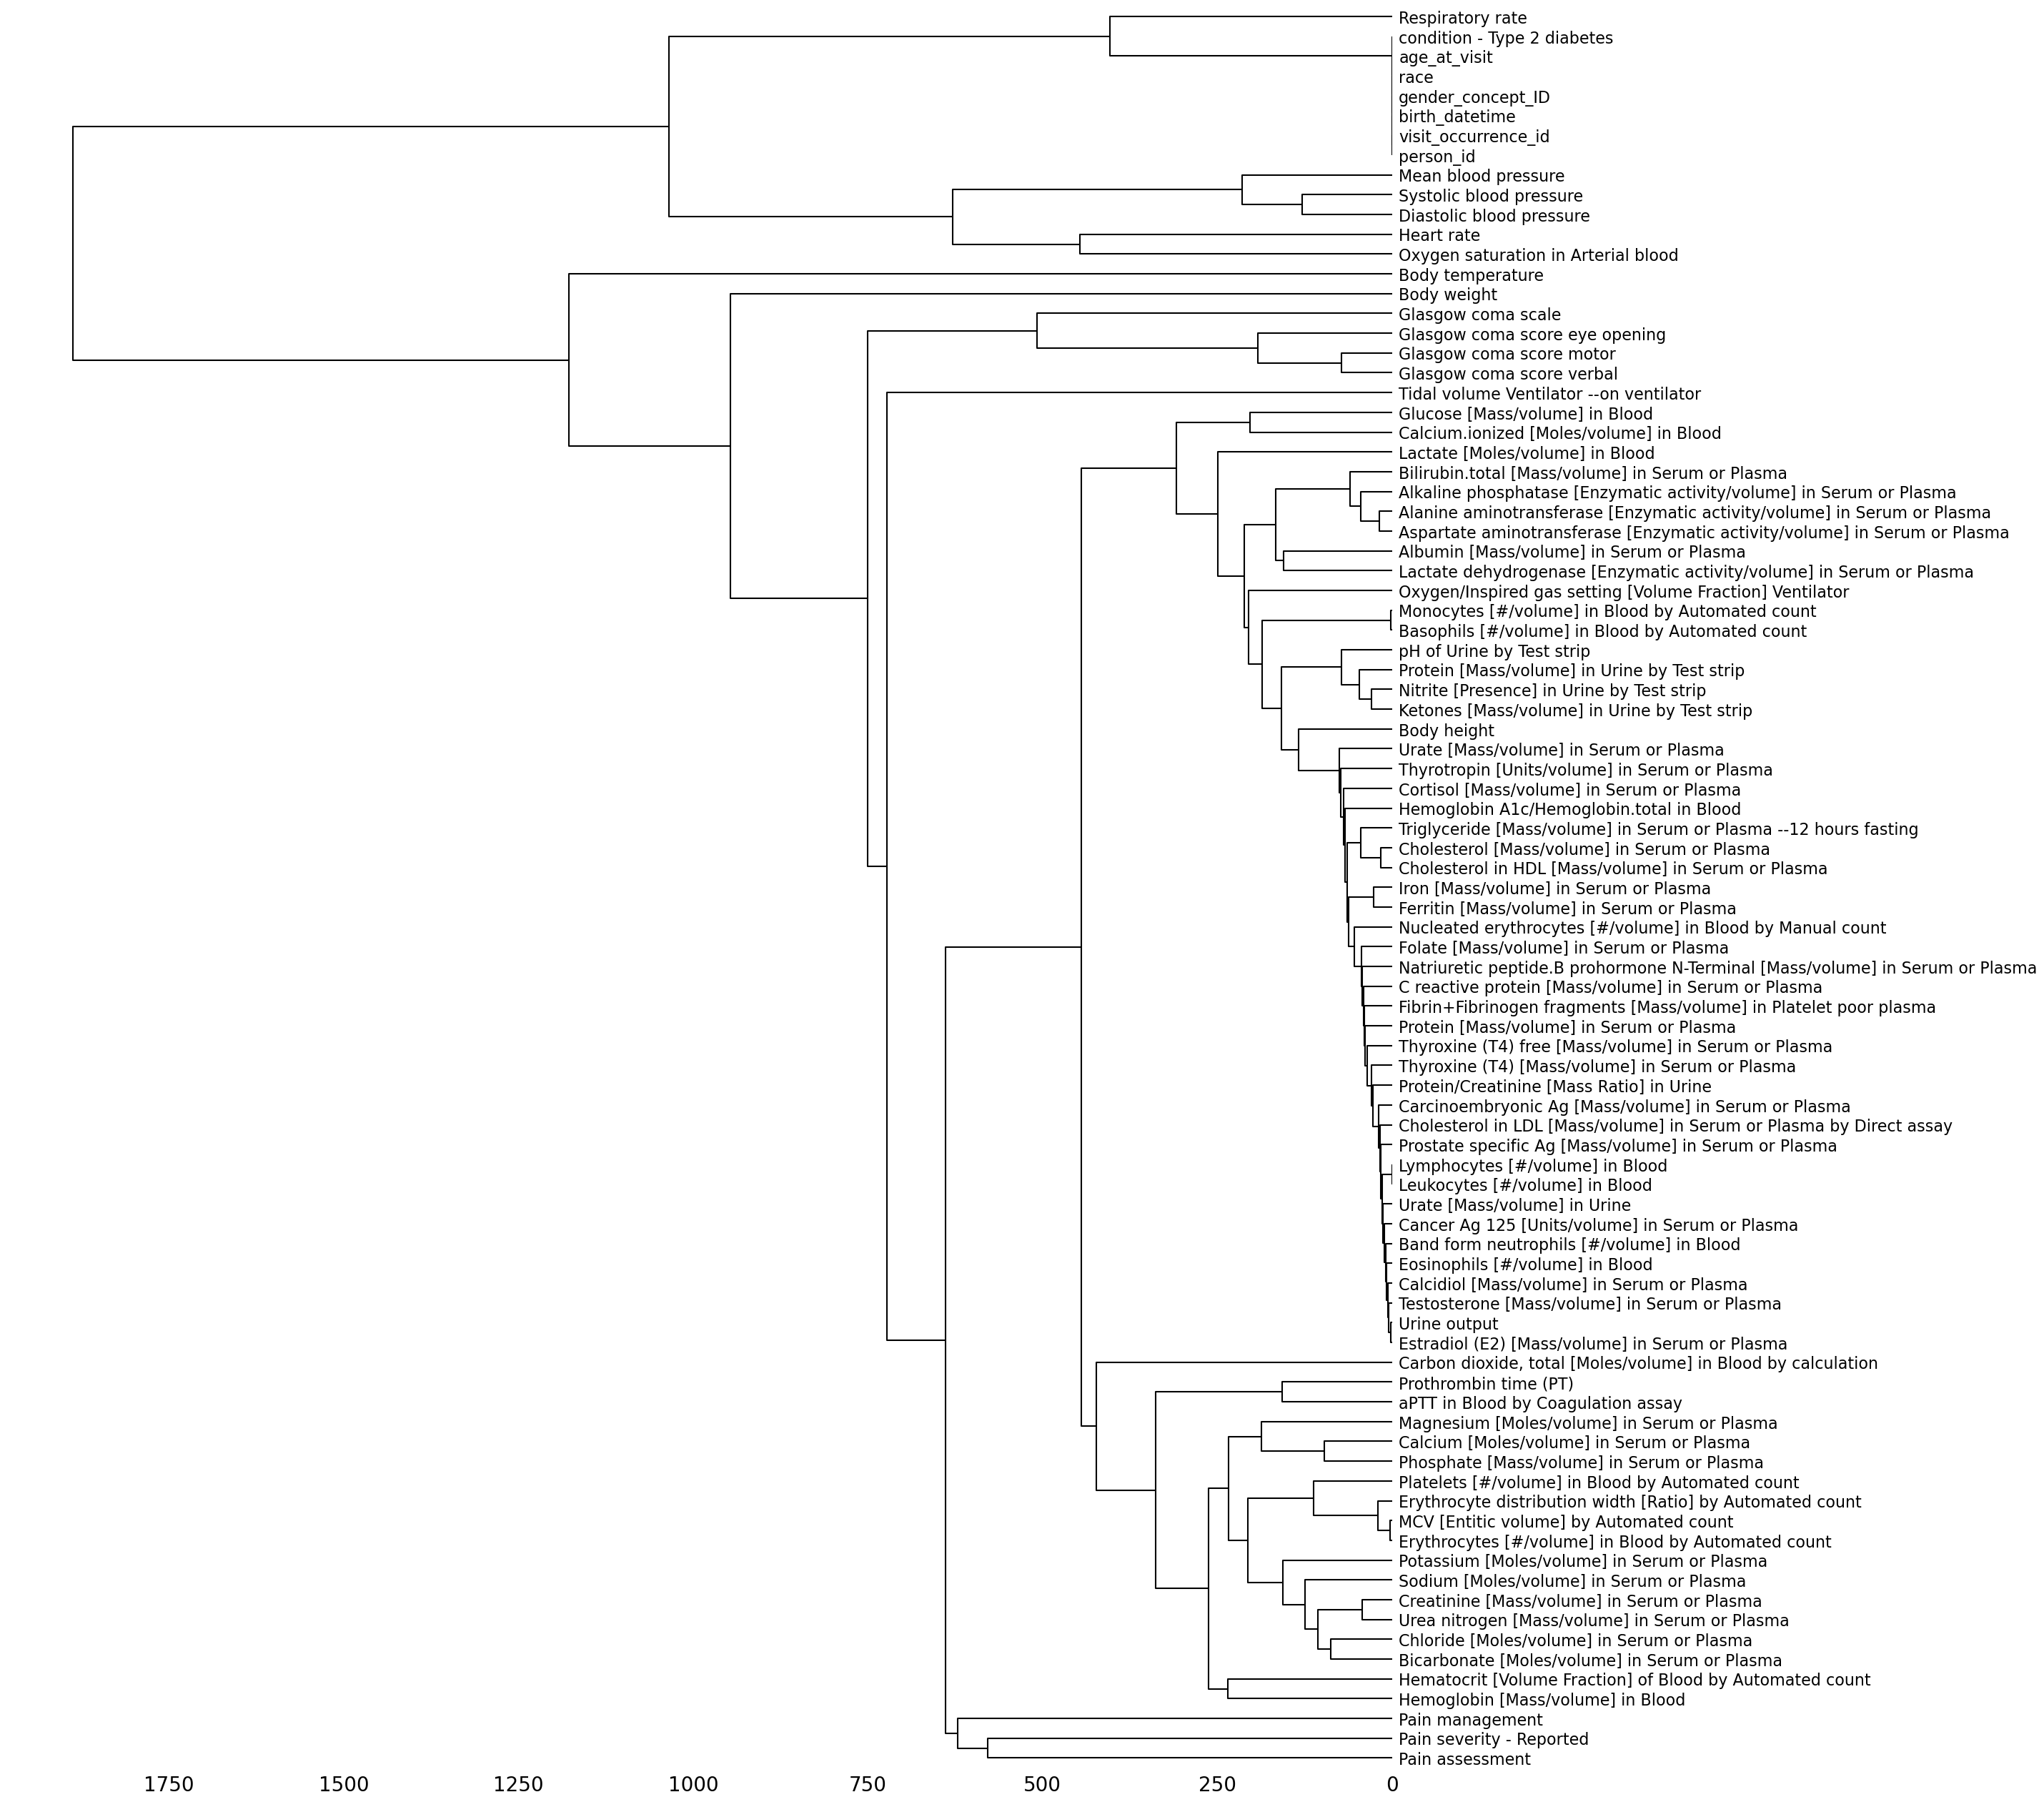

In [222]:
msno.dendrogram(df_cleaned3)

Seperating Features into numercial and categorical features

In [237]:
numerical_features = [
    'age_at_visit',
    'Mean blood pressure',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Heart rate',
    'Body temperature',
    'Oxygen saturation in Arterial blood',
    'Glucose [Mass/volume] in Blood',
    'Bilirubin.total [Mass/volume] in Serum or Plasma',
    'Creatinine [Mass/volume] in Serum or Plasma',
    'Urea nitrogen [Mass/volume] in Serum or Plasma',
    'Sodium [Moles/volume] in Serum or Plasma',
    'Potassium [Moles/volume] in Serum or Plasma',
    'Chloride [Moles/volume] in Serum or Plasma',
    'Calcium.ionized [Moles/volume] in Blood',
    'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
    'Hemoglobin [Mass/volume] in Blood',
    'Hematocrit [Volume Fraction] of Blood by Automated count',
    'Erythrocyte distribution width [Ratio] by Automated count',
    'MCV [Entitic volume] by Automated count',
    'Platelets [#/volume] in Blood by Automated count',
    'Lymphocytes [#/volume] in Blood',
    'Leukocytes [#/volume] in Blood',
    'Eosinophils [#/volume] in Blood',
    'Monocytes [#/volume] in Blood by Automated count',
    'Nucleated erythrocytes [#/volume] in Blood by Manual count',
    'Band form neutrophils [#/volume] in Blood',
    'Prothrombin time (PT)',
    'aPTT in Blood by Coagulation assay',
    'Lactate [Moles/volume] in Blood',
    'Lactate dehydrogenase [Enzymatic activity/volume] in Serum or Plasma',
    'Cholesterol [Mass/volume] in Serum or Plasma',
    'Triglyceride [Mass/volume] in Serum or Plasma --12 hours fasting',
    'Cholesterol in HDL [Mass/volume] in Serum or Plasma',
    'Cholesterol in LDL [Mass/volume] in Serum or Plasma by Direct assay',
    'Natriuretic peptide.B prohormone N-Terminal [Mass/volume] in Serum or Plasma',
    'Protein/Creatinine [Mass Ratio] in Urine',
    'Urine output',
    'Urate [Mass/volume] in Serum or Plasma',
    'Urate [Mass/volume] in Urine',
    'pH of Urine by Test strip',
    'Bicarbonate [Moles/volume] in Serum or Plasma',
    'Carbon dioxide, total [Moles/volume] in Blood by calculation',
    'Thyrotropin [Units/volume] in Serum or Plasma',
    'Thyroxine (T4) [Mass/volume] in Serum or Plasma',
    'Thyroxine (T4) free [Mass/volume] in Serum or Plasma',
    'Cortisol [Mass/volume] in Serum or Plasma',
    'Calcidiol [Mass/volume] in Serum or Plasma',
    'Testosterone [Mass/volume] in Serum or Plasma',
    'Estradiol (E2) [Mass/volume] in Serum or Plasma',
    'Carcinoembryonic Ag [Mass/volume] in Serum or Plasma',
    'Cancer Ag 125 [Units/volume] in Serum or Plasma',
    'Prostate specific Ag [Mass/volume] in Serum or Plasma',
    'Iron [Mass/volume] in Serum or Plasma',
    'Ferritin [Mass/volume] in Serum or Plasma',
    'Folate [Mass/volume] in Serum or Plasma',
    'Magnesium [Moles/volume] in Serum or Plasma',
    'Glasgow coma scale',
    'Body weight',
    'Oxygen/Inspired gas setting [Volume Fraction] Ventilator',
    'Tidal volume Ventilator --on ventilator',
    'Phosphate [Mass/volume] in Serum or Plasma'
]



In [256]:
categorical_features = [
    'race',
    'gender_concept_ID',
    'visit_occurrence_id',
    'person_id',
    'Glasgow coma score eye opening',
    'Glasgow coma score motor',
    'Glasgow coma score verbal',
    'Pain severity - Reported',
    'Pain assessment',
    'Pain management',
    'Protein [Mass/volume] in Urine by Test strip',
    'Nitrite [Presence] in Urine by Test strip',
    'Ketones [Mass/volume] in Urine by Test strip'
]

Let's firstly deal with numerical data and deal with missing data

In [238]:
for feature in numerical_features:
    df_cleaned3[feature] = pd.to_numeric(df_cleaned3[feature], errors='coerce')

In [228]:
df_cleaned3['condition_type_2_diabetes_encoded'] = df_cleaned3['condition - Type 2 diabetes'].map({'Absence': 0, 'Presence': 1})
print(df_cleaned3['condition_type_2_diabetes_encoded'].unique())

[0 1]


In [264]:
# Calculate the percentage of missing values for each feature
missing_percentages = df_cleaned3[numerical_features].isnull().mean() * 100
# Filter and print out features with more than 90% missing values
features_to_drop = missing_percentages[missing_percentages > 90].index.tolist()
print(features_to_drop)

['Glucose [Mass/volume] in Blood', 'Bilirubin.total [Mass/volume] in Serum or Plasma', 'Creatinine [Mass/volume] in Serum or Plasma', 'Urea nitrogen [Mass/volume] in Serum or Plasma', 'Sodium [Moles/volume] in Serum or Plasma', 'Potassium [Moles/volume] in Serum or Plasma', 'Chloride [Moles/volume] in Serum or Plasma', 'Calcium.ionized [Moles/volume] in Blood', 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma', 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma', 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma', 'Hemoglobin [Mass/volume] in Blood', 'Hematocrit [Volume Fraction] of Blood by Automated count', 'Erythrocyte distribution width [Ratio] by Automated count', 'MCV [Entitic volume] by Automated count', 'Platelets [#/volume] in Blood by Automated count', 'Lymphocytes [#/volume] in Blood', 'Leukocytes [#/volume] in Blood', 'Eosinophils [#/volume] in Blood', 'Monocytes [#/volume] in Blood by Automated count', 'Nuc

In [266]:
df_cleaned4 = df_cleaned3.drop(columns=features_to_drop)

# Verify the drop by printing out the remaining columns
print(df_cleaned4.columns)

Index(['Hemoglobin A1c/Hemoglobin.total in Blood',
       'Calcium [Moles/volume] in Serum or Plasma',
       'Albumin [Mass/volume] in Serum or Plasma',
       'Protein [Mass/volume] in Serum or Plasma',
       'C reactive protein [Mass/volume] in Serum or Plasma', 'Body weight',
       'Body height', 'Body temperature', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Mean blood pressure', 'Heart rate',
       'Oxygen saturation in Arterial blood',
       'Protein [Mass/volume] in Urine by Test strip',
       'Nitrite [Presence] in Urine by Test strip',
       'Ketones [Mass/volume] in Urine by Test strip', 'Respiratory rate',
       'Tidal volume Ventilator --on ventilator',
       'Fibrin+Fibrinogen fragments [Mass/volume] in Platelet poor plasma',
       'Glasgow coma score eye opening', 'Glasgow coma score motor',
       'Glasgow coma score verbal', 'Glasgow coma scale',
       'Pain severity - Reported', 'Pain assessment', 'Pain management',
       'Erythrocytes [#

In [271]:
threshold = len(df_cleaned4.columns) - 15
df_reduced = df_cleaned4.dropna(thresh=threshold)

# Check the shape of the DataFrame before and after
print("Original DataFrame shape:", df_cleaned4.shape)
print("Reduced DataFrame shape:", df_reduced.shape)

Original DataFrame shape: (4157787, 35)
Reduced DataFrame shape: (472587, 35)


In [274]:
missing_percentages2 = df_reduced.isnull().mean() * 100
# drop out features with more than 50% missing values
features_to_drop2 = missing_percentages2[missing_percentages2 > 50].index.tolist()
print(features_to_drop2)
df_cleaned5 = df_reduced.drop(columns=features_to_drop2)

# Verify the drop by printing out the remaining columns
print(df_cleaned5.columns)

['Hemoglobin A1c/Hemoglobin.total in Blood', 'Calcium [Moles/volume] in Serum or Plasma', 'Albumin [Mass/volume] in Serum or Plasma', 'Protein [Mass/volume] in Serum or Plasma', 'C reactive protein [Mass/volume] in Serum or Plasma', 'Body height', 'Protein [Mass/volume] in Urine by Test strip', 'Nitrite [Presence] in Urine by Test strip', 'Ketones [Mass/volume] in Urine by Test strip', 'Fibrin+Fibrinogen fragments [Mass/volume] in Platelet poor plasma', 'Pain management', 'Erythrocytes [#/volume] in Blood by Automated count', 'Basophils [#/volume] in Blood by Automated count']
Index(['Body weight', 'Body temperature', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Mean blood pressure', 'Heart rate',
       'Oxygen saturation in Arterial blood', 'Respiratory rate',
       'Tidal volume Ventilator --on ventilator',
       'Glasgow coma score eye opening', 'Glasgow coma score motor',
       'Glasgow coma score verbal', 'Glasgow coma scale',
       'Pain severity - Reported

In [275]:
df_cleaned5.head()

,Body weight,Body temperature,Systolic blood pressure,Diastolic blood pressure,Mean blood pressure,Heart rate,Oxygen saturation in Arterial blood,Respiratory rate,Tidal volume Ventilator --on ventilator,Glasgow coma score eye opening,...,Glasgow coma scale,Pain severity - Reported,Pain assessment,visit_occurrence_id,person_id,gender_concept_ID,race,age_at_visit,condition - Type 2 diabetes,condition_type_2_diabetes_encoded
0,75.0,37.777802,130.0,72.0,69.0,75.0,95.0,36,480.0,4 Spontaneously,...,11.0,3-Mild to Mod,Non-verbal cues,541,392775850,F,WHITE,74,Absence,0
1,75.0,37.000000,135.0,62.0,88.0,89.0,100.0,10,450.0,4 Spontaneously,...,11.0,Unable to score,Pt Verbalized,541,392775850,F,WHITE,74,Absence,0
2,75.0,37.111099,134.0,79.0,110.0,95.0,99.0,30,450.0,3 To speech,...,10.0,Unable to score,Pt Verbalized,541,392775850,F,WHITE,74,Absence,0
3,75.0,36.888901,147.0,78.0,110.0,104.0,97.0,10,450.0,4 Spontaneously,...,15.0,3-Mild to Mod,Pt Verbalized,541,392775850,F,WHITE,74,Absence,0
4,75.0,38.111099,154.0,80.0,80.0,108.0,98.0,10,448.0,4 Spontaneously,...,11.0,Unable to score,Pt Verbalized,541,392775850,F,WHITE,74,Absence,0


In [276]:
print(df_cleaned5['condition - Type 2 diabetes'].value_counts())

condition - Type 2 diabetes
Absence     446648
Presence     25939
Name: count, dtype: int64


In [292]:
df_cleaned_final = df_cleaned5.drop(columns=['condition - Type 2 diabetes', 'visit_occurrence_id', 'person_id'])

## fill all the NA value with mean and mode, and use one hot encoding to encode catergorical features

In [293]:
df_cleaned_final['Respiratory rate'] = pd.to_numeric(df_cleaned_final['Respiratory rate'], errors='coerce')

In [294]:
for column in df_cleaned_final.select_dtypes(include=[np.number]).columns:
    df_cleaned_final[column].fillna(df_cleaned_final[column].mean(), inplace=True)

# Fill categorical features with their mode
for column in df_cleaned_final.select_dtypes(include=['object', 'category']).columns:
    mode_value = df_cleaned_final[column].mode()[0]  # mode() returns a Series, get the first value
    df_cleaned_final[column].fillna(mode_value, inplace=True)

In [297]:
categorical_columns = df_cleaned_final.select_dtypes(include=['object', 'category']).columns
df = pd.get_dummies(df_cleaned_final, columns=categorical_columns, drop_first=True, prefix_sep='__')

## Start training model

In [298]:
# Separate the features and target variable
X = df.drop('condition_type_2_diabetes_encoded', axis=1)  # Feature set
y = df['condition_type_2_diabetes_encoded']  # Target variable

# Split the dataset into training and temporary sets (80-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Further split the temporary set into validation and test sets (50-50 split)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp)


In [299]:
parameters = [
    {'max_iter': [1000], 'C': [100]},  # Parameters for Logistic Regression
    {'max_features': ['sqrt'], 'max_depth': [8]},  # Parameters for Random Forest
    {'max_depth': [2, 4, 6, 8], 'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.05]}  # Parameters for XGBoost
]

# Define the models
models = [
    linear_model.LogisticRegression(),
    RandomForestClassifier(),
    XGBClassifier(objective='binary:logistic', enable_categorical=True)
]

# Variables to store the best model's information
index_best = -1
best_score = -np.Inf
best_class = None

# GridSearchCV for each model
for index, model in enumerate(models):
    clf = GridSearchCV(model, parameters[index], scoring='roc_auc')
    clf.fit(X_train, y_train)
    validation_score = clf.score(X_valid, y_valid)
    print(f'Validation score: {validation_score:.3}, Index: {index}, Best params: {clf.best_params_}')
    
    if validation_score > best_score:
        best_score = validation_score
        index_best = index
        best_class = model

print(f'Best validation score: {best_score:.3}, Best index: {index_best}, Best classifier: {best_class}')

Validation score: 0.688, Index: 0, Best params: {'C': 100, 'max_iter': 1000}
Validation score: 0.797, Index: 1, Best params: {'max_depth': 8, 'max_features': 'sqrt'}
Validation score: 0.951, Index: 2, Best params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}
Best validation score: 0.951, Best index: 2, Best classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n

## Test model performance using AUC, PR-AUC, and calibration

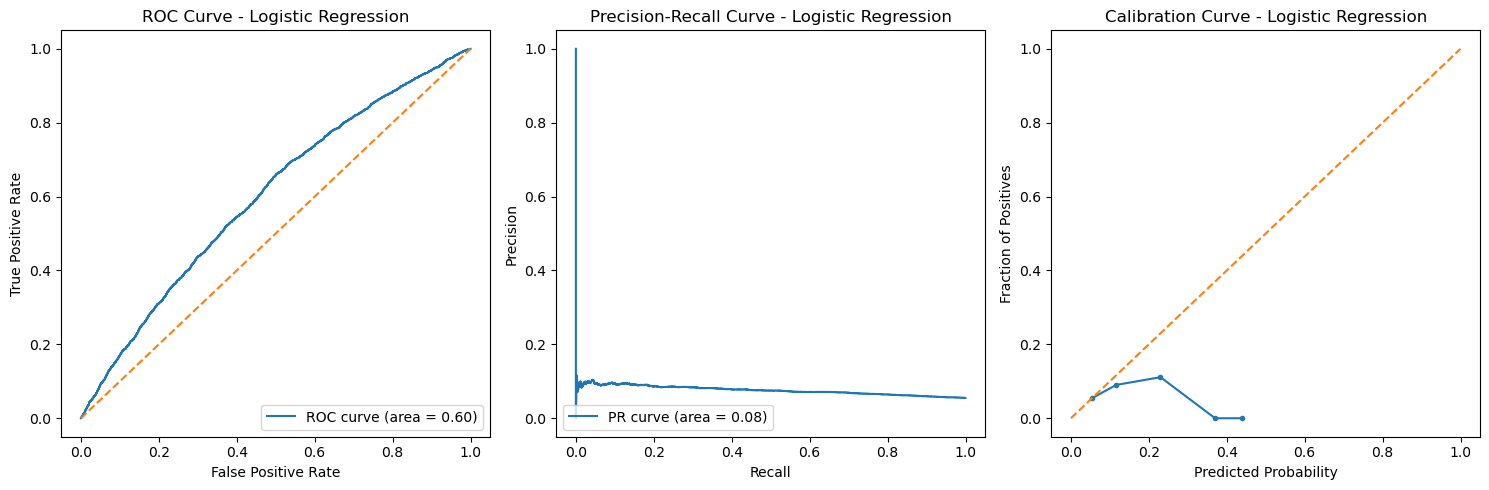

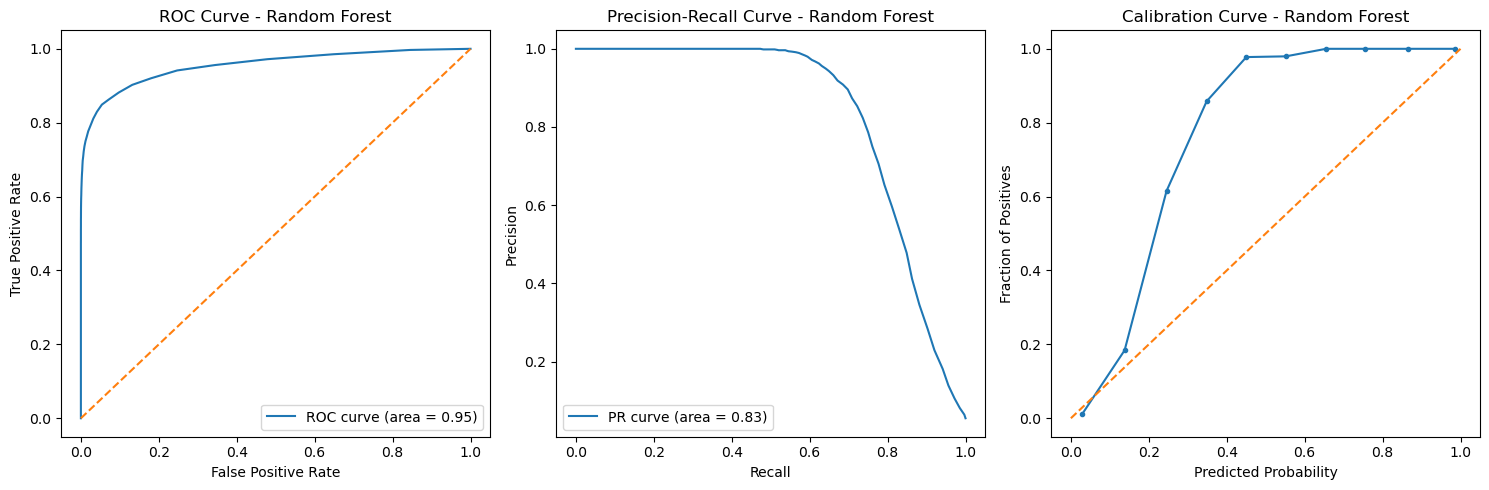

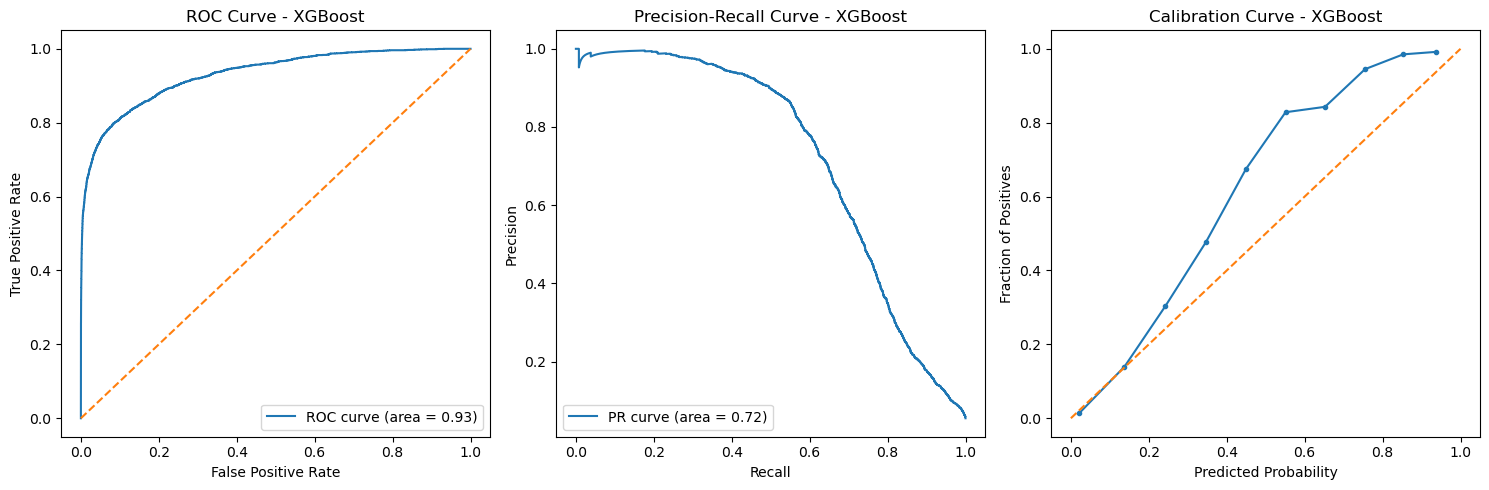

In [300]:
# Initialize models
logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier()
xgboost_model = XGBClassifier()

# Fit models
logistic_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)

# Define a function to plot ROC, PR, and Calibration curves
def plot_model_performance(model, X_test, y_test, model_name):
    # Predict probabilities
    probs = model.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    # Calculate PR AUC
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = average_precision_score(y_test, probs)

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

    # Plotting
    plt.figure(figsize=(15, 5))

    # ROC Curve
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')

    # Calibration Curve
    plt.subplot(1, 3, 3)
    plt.plot(prob_pred, prob_true, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - {model_name}')

    plt.tight_layout()
    plt.show()

# Plot performance for each model
plot_model_performance(logistic_model, X_test, y_test, 'Logistic Regression')
plot_model_performance(random_forest_model, X_test, y_test, 'Random Forest')
plot_model_performance(xgboost_model, X_test, y_test, 'XGBoost')

## interpretability and explainability

Develop Odds ratio for top 10 variables of importance (use random forest and XG Boost model)

In [302]:
# Fit the model
random_forest_model.fit(X_train, y_train)

# Get feature importances
feature_importances_rf = random_forest_model.feature_importances_

# Create a DataFrame for easy viewing
feature_importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})

# Sort the DataFrame by importance
sorted_feature_importance_df_rf = feature_importance_df_rf.sort_values('Importance', ascending=False)

# Display the top 10 variables
print(sorted_feature_importance_df_rf.head(10))

                                    Feature  Importance
10                             age_at_visit    0.120666
5                                Heart rate    0.080962
1                          Body temperature    0.078929
2                   Systolic blood pressure    0.074904
4                       Mean blood pressure    0.073056
0                               Body weight    0.070363
3                  Diastolic blood pressure    0.068773
7                          Respiratory rate    0.064086
8   Tidal volume Ventilator --on ventilator    0.059662
6       Oxygen saturation in Arterial blood    0.043309


In [303]:
# Fit the model
xgboost_model.fit(X_train, y_train)

# Get feature importances
feature_importances_xgb = xgboost_model.feature_importances_

# Create a DataFrame for easy viewing
feature_importance_df_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_xgb})

# Sort the DataFrame by importance
sorted_feature_importance_df_xgb = feature_importance_df_xgb.sort_values('Importance', ascending=False)

# Display the top 10 variables
print(sorted_feature_importance_df_xgb.head(10))


                                          Feature  Importance
62                 Pain assessment__Grimace Scale    0.093830
84                   race__BLACK/AFRICAN AMERICAN    0.046387
28        Glasgow coma score verbal__1.0 ET/Trach    0.031623
86                            race__BLACK/HAITIAN    0.029433
71                           gender_concept_ID__M    0.026973
16      Glasgow coma score eye opening__To Speech    0.026422
107                                   race__WHITE    0.023788
53   Pain severity - Reported__Moderate to Severe    0.022660
10                                   age_at_visit    0.022269
64               Pain assessment__Non-verbal cues    0.021909


Develop SHAP summary plot, feature importance with top 20 variables

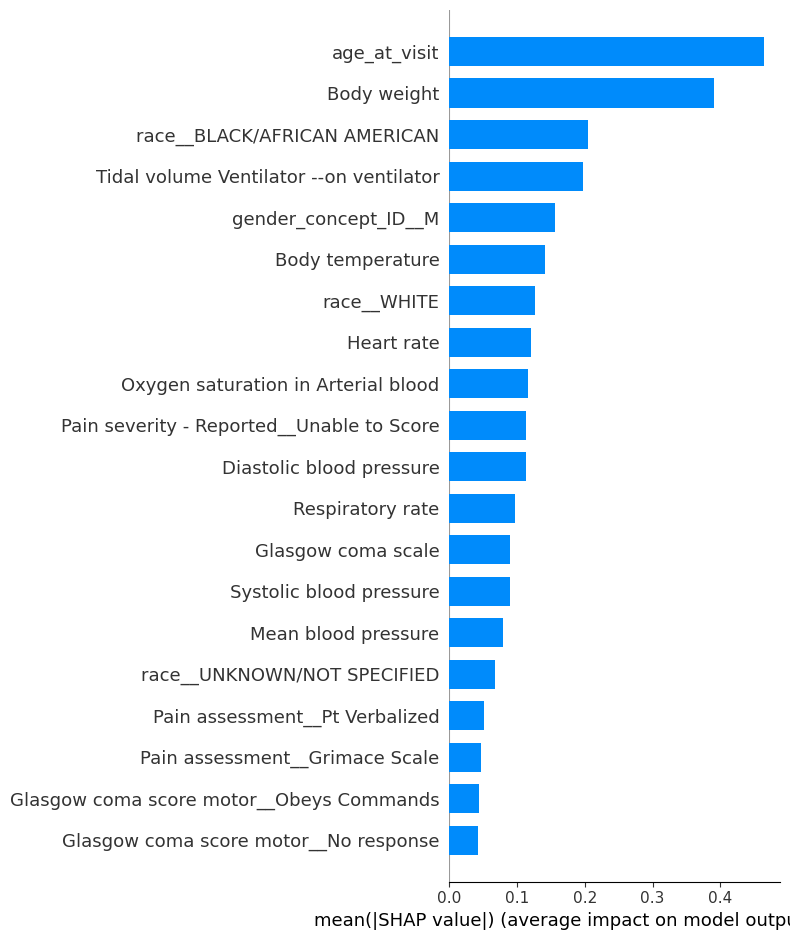

In [304]:
import shap
import xgboost as xgb

X_train_encoded = X_train.astype(int)

# Train the XGBoost model on the encoded data
xgb_model = xgb.XGBClassifier().fit(X_train_encoded, y_train)

# Calculate SHAP values using TreeExplainer which is optimized for tree-based models like XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_encoded)

# Summary plot for the top 20 features
shap.summary_plot(shap_values, X_train_encoded, plot_type="bar", max_display=20)

Create SHAP force plot for 5 visits

In [305]:
import random
random_indices = random.sample(range(X_train_encoded.shape[0]), 5)

# Initialize JavaScript visualization for Jupyter notebooks (if applicable)
shap.initjs()

# Generate SHAP force plots for the 5 random visits
for i in random_indices:
    # Display SHAP force plot for the current visit
    display(shap.force_plot(explainer.expected_value, shap_values[i], X_train_encoded.iloc[i]))

    # Get binary prediction for the current visit
    binary_prediction = xgb_model.predict(X_train_encoded.iloc[i:i+1])[0]
    print(f'Visit index: {i}, Binary prediction: {binary_prediction}')

Visit index: 150452, Binary prediction: 0


Visit index: 9942, Binary prediction: 0


Visit index: 328632, Binary prediction: 0


Visit index: 96768, Binary prediction: 0


Visit index: 149542, Binary prediction: 0
